 # Rainfall Prediction: Modeling Notebook

 ## 1. Load Processed Data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import joblib

# Load processed data
train = pd.read_csv('data/train_processed.csv')
test = pd.read_csv('data/test_processed.csv')

# Load original test data for IDs
original_test = pd.read_csv('data/test.csv')
test_ids = original_test['id']

# Prepare features and target
X = train.drop('rainfall', axis=1)
y = train['rainfall']

# Check class distribution
print("Class distribution:\n", y.value_counts(normalize=True))


Class distribution:
 rainfall
1    0.753425
0    0.246575
Name: proportion, dtype: float64


 ## 2. Train-Validation Split

In [5]:
# Stratified split to maintain class distribution
X_train, X_val, y_train, y_val = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=42
)

print(f"Training data: {X_train.shape}")
print(f"Validation data: {X_val.shape}")


Training data: (1752, 18)
Validation data: (438, 18)


 ## 3. Model Training & Evaluation

 ### 3.1 Initialize Models & Hyperparameters

In [6]:
models = {
    'Logistic Regression': {
        'model': LogisticRegression(class_weight='balanced', random_state=42),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear']
        }
    },
    'Random Forest': {
        'model': RandomForestClassifier(class_weight='balanced', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(class_weight='balanced', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1],
            'max_depth': [3, 5],
            'subsample': [0.8, 1.0]
        }
    }
}


 ### 3.2 Model Training with Cross-Validation

In [7]:
best_models = {}
results = []

for name, config in models.items():
    print(f"\nTraining {name}...")
    
    # Grid search with stratified K-fold
    gs = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        scoring='roc_auc',
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        n_jobs=-1
    )
    
    gs.fit(X_train, y_train)
    
    # Store best model
    best_models[name] = gs.best_estimator_
    
    # Validation performance
    val_pred = gs.predict_proba(X_val)[:, 1]
    val_auc = roc_auc_score(y_val, val_pred)
    
    results.append({
        'Model': name,
        'Best Params': gs.best_params_,
        'Validation AUC': val_auc
    })

# Display results
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
display(results_df)



Training Logistic Regression...

Training Random Forest...

Training XGBoost...


c:\Users\kresi\miniconda3\envs\machine_learning\lib\site-packages\xgboost\core.py:158: UserWarning: [13:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Training LightGBM...
[LightGBM] [Info] Number of positive: 1320, number of negative: 432
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2275
[LightGBM] [Info] Number of data points in the train set: 1752, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

,Model,Best Params,Validation AUC
0,Logistic Regression,"{'C': 0.1, 'penalty': 'l2', 'solver': 'libline...",0.879237
1,Random Forest,"{'max_depth': 10, 'min_samples_split': 5, 'n_e...",0.872952
2,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.873527
3,LightGBM,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.872320


 ### 3.3 Model Evaluation

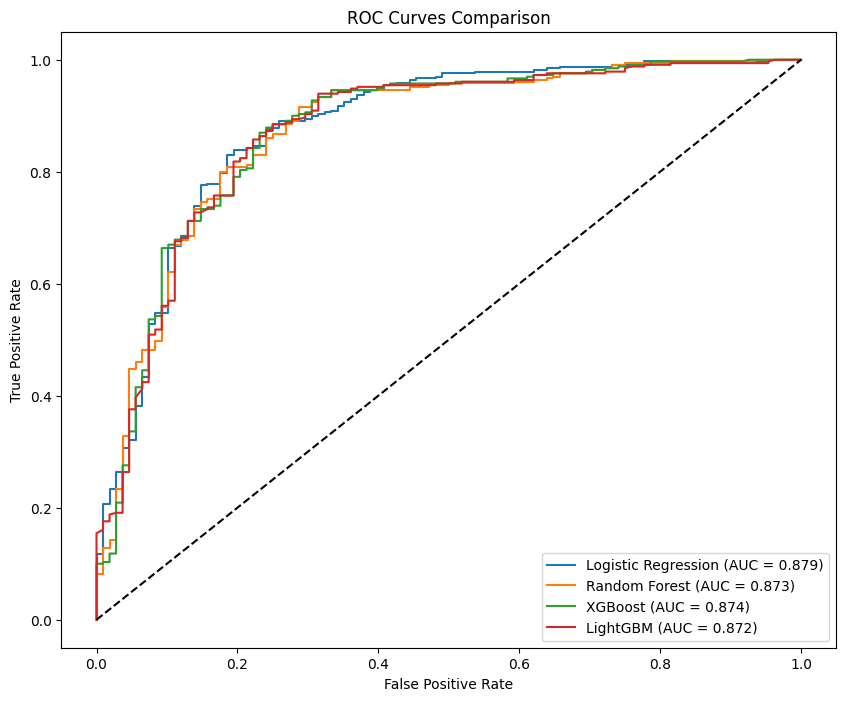

In [8]:
# Plot ROC curves
plt.figure(figsize=(10, 8))
for name, model in best_models.items():
    preds = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, preds)
    auc_score = roc_auc_score(y_val, preds)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.show()


 ## 4. Feature Importance Analysis

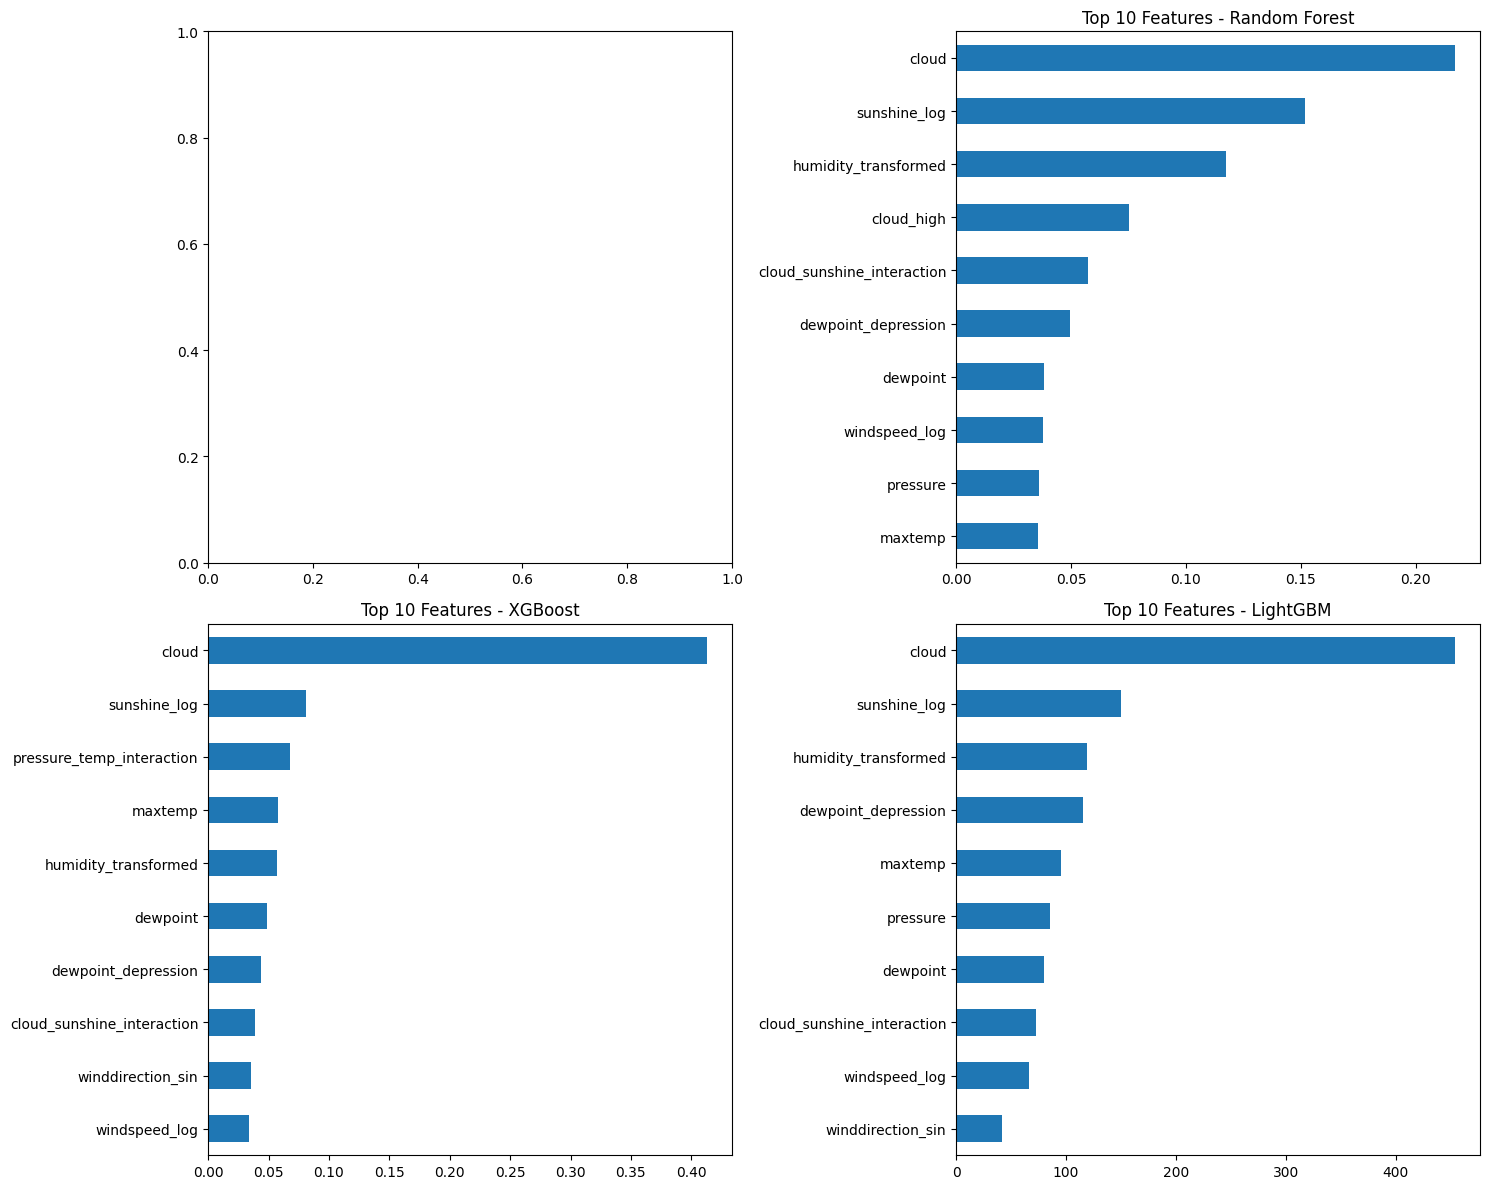

In [9]:
# Plot feature importance for tree-based models
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

for idx, (name, model) in enumerate(best_models.items()):
    if hasattr(model, 'feature_importances_'):
        ax = axes[idx//2, idx%2]
        importances = pd.Series(model.feature_importances_, index=X.columns)
        importances.sort_values().tail(10).plot(kind='barh', ax=ax)
        ax.set_title(f'Top 10 Features - {name}')
        
plt.tight_layout()
plt.show()


 ## 5. Final Model Training & Submission

In [10]:
# Select best model based on validation performance
best_model_name = results_df.loc[results_df['Validation AUC'].idxmax(), 'Model']
final_model = best_models[best_model_name]

print(f"\nSelected Best Model: {best_model_name}")

# Retrain on full dataset
final_model.fit(X, y)

# Save model
joblib.dump(final_model, 'best_model.pkl')

# Predict on test set
test_pred = final_model.predict_proba(test)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'id': test_ids,
    'rainfall': test_pred
})

# Save submission
submission.to_csv('submission.csv', index=False)

print("\nSubmission file created successfully!")
print("First 5 predictions:")
print(submission.head())



Selected Best Model: Logistic Regression

Submission file created successfully!
First 5 predictions:
     id  rainfall
0  2190  0.979474
1  2191  0.986032
2  2192  0.843138
3  2193  0.036562
4  2194  0.016246
